# Fresnel Masivo

Se agrega la característica altura, que fue procesada de manera manual y se almacenó directamente en el Data Mart. Luego se agrega la información correspondiente al primer salto, de modo que se completan los campos necesarios para calcular la característica Fresnel.

En un proceso previo, durante la generación de la característica altimetría se descargó la información masiva desde la API de elevación de Google. Acá se utiliza esa información almacenada en formato parquet, se obtienen de la API los posibles faltantes. Luego se seleccionan los valores únicos de radio enlaces existentes en el conjunto de datos, se genera la característica Fresnel para estos valores únicos y por último se agrega la característica al conjunto de datos.

También se agrega en este punto la característica de momentos de color, dado que se demostró capaz de contener información útil como para identificar anomalías.

In [1]:
#Importando librerias
import sys
import urllib
import warnings
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('../../')
#from Python.FeatureEngeeniering.Fresnel.fresnelFeature import fresnelAnalysis3
from Python.FeatureEngeeniering.Fresnel.fresnelFeature import *
from Python.Extraction.alturasFuncs import *
from Python.Style.styles import  *
import tensorflow as tf
from Python.Preprocessing.funcs import  *


In [2]:
warnings.filterwarnings("ignore")
pd.set_option('display.float_format',  '{:,.8f}'.format)

In [3]:
#Utilizando diseño base 1
plt.style.use('../../Python/Style/style1.mplstyle')

In [4]:
#Colores base
#Diseño base
mClr = designC['cs']
mClr_d2 = plt.get_cmap('cs-d')(2)
sClr1 = designC['nr']
sClr1_d2 = plt.get_cmap('nr-d')(2)
sClr3 = designC['az']
sClr2 = designC['gr']
sClr2_d = plt.get_cmap('gr-d')(0)
sClr2_d2 = plt.get_cmap('gr-d')(2)
sClr4 = designC['vr']
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 120

## Agregando información de alturas

In [5]:
#Leyendo alturas
h_mg = pd.read_parquet('../../Data/DataMart/Alturas/mg_h.parquet')
h_mr = pd.read_parquet('../../Data/DataMart/Alturas/mr_h.parquet')
h_mc = pd.read_parquet('../../Data/DataMart/Alturas/mc_h.parquet')

In [6]:
#Leyendo dfs
equipos = pd.read_parquet('../../Data/DataMart/Views/DataViews/equipos.parquet')
mg_df = pd.read_parquet('../../Data/DataMart/Views/DataViews/reduced_mg.parquet')

In [7]:
#Convirtiendo serial number
h_mg['serialNumber'] = h_mg['serialNumber'].astype(str)
h_mr['serialNumber'] = h_mr['serialNumber'].astype(str)
h_mc['serialNumber'] = h_mc['serialNumber'].astype(str)

In [8]:
#Agregando altura
print(f"Equipos shape: {equipos.shape}")
print(f"MG shape: {mg_df.shape}")

#Agrupando alturas mc y mr
h_equipos = pd.concat([h_mc, h_mr], axis=0, ignore_index=True)
h_equipos['serialNumber'] = h_equipos['serialNumber'].astype(str)
h_mg['serialNumber'] = h_mg['serialNumber'].astype(str)

#Haciendo merge
equipos = equipos.merge(h_equipos, on='serialNumber', how='left')
mg_df = mg_df.merge(h_mg, on='serialNumber', how='left')

print(f"Equipos shape con altura: {equipos.shape}")
print(f"MG shape con altura: {mg_df.shape}")

Equipos shape: (773870, 18)
MG shape: (953, 18)
Equipos shape con altura: (773870, 19)
MG shape con altura: (953, 19)


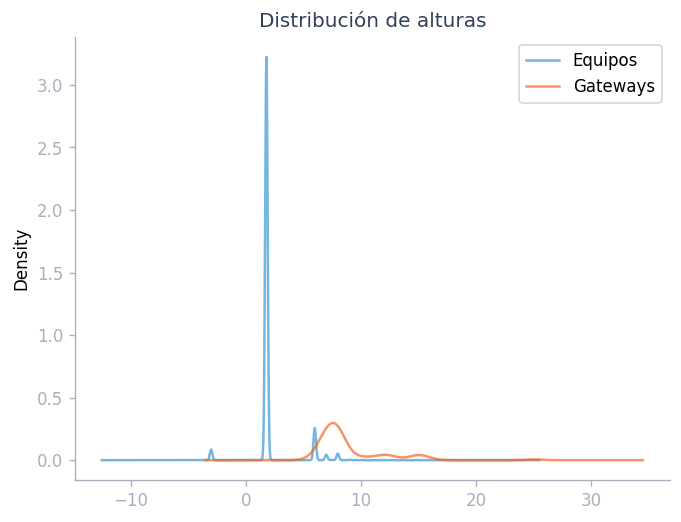

In [9]:
#Visualizando distribuciones de altura
equipos['h'].plot(kind='kde', color=mClr, alpha=0.7, label='Equipos')
mg_df['h'].plot(kind='kde', color=sClr1, alpha=0.7, label ='Gateways')
plt.legend()
plt.title('Distribución de alturas')
plt.show()

In [10]:
#Visualizando vacíos en altura
print(f"Equipos con altura nula: {equipos['h'].isna().sum()}")
print(f"MG con altura nula: {mg_df['h'].isna().sum()}")

Equipos con altura nula: 0
MG con altura nula: 0


## Agregando color moments

In [11]:
#Creando batches
#Parámetros de imagen
IMAGE_SIZE = (99, 99)
BATCH_SIZE = 100

#Creando dataset desde directorio
dataset = tf.data.Dataset.list_files("../../Data/DataMart/transformedImages/*.*")

def load_and_preprocess_image_with_path(path):
    #Leyendo y decodificando imagen
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    #Redimensionando y normalizando
    image = tf.image.resize(image, IMAGE_SIZE)
    image /= 255.0
    return image, path

#Mapeando función de preprocesamiento
t_dataset_with_path = dataset.map(load_and_preprocess_image_with_path)

#Creando batches del dataset
dataset_with_path = t_dataset_with_path.batch(BATCH_SIZE)

In [12]:
total_batches = len(list(dataset_with_path))
print(f"Número de batches a procesar: {total_batches}")

Número de batches a procesar: 257


In [13]:
def calculate_color_moments(image):
    #Convertir a float para evitar problemas de overflow en la potenciación
    image = image.astype('float32')
    moments = {}
    for i, channel_color in enumerate(['R', 'G', 'B']):
        channel_data = image[:, :, i]
        mean = np.mean(channel_data)
        variance = np.var(channel_data)
        skewness = np.mean((channel_data - mean)**3)
        moments[f'{channel_color}_mean'] = mean
        moments[f'{channel_color}_variance'] = variance
        moments[f'{channel_color}_skewness'] = skewness
    return moments

In [14]:
#Almacenando característica y nombres
all_batches_color_moments = []
names_color_moments = []

#Iterando batch dataset
for batch in dataset_with_path.take(total_batches):
    batch_color_moments = []
    
    for count, img in enumerate(batch[0]):
        #Convertir la imagen a un array NumPy
        img_numpy = img.numpy()
        
        #Calculando momentos
        color_moments = calculate_color_moments(img_numpy)
        
        #Agregando momentos y nombre
        batch_color_moments.append(color_moments)
        tempName = batch[1][count].numpy()
        tempName = tempName.decode("utf-8")
        tempName = tempName.split("/")[-1]
        names_color_moments.append(tempName)
    
    all_batches_color_moments.append(batch_color_moments)

first_image_first_batch_moments = all_batches_color_moments[0][0]
print(f"Color moments of the first image in the first batch: {first_image_first_batch_moments}")

Color moments of the first image in the first batch: {'R_mean': 0.49454132, 'R_variance': 0.07700672, 'R_skewness': -0.0003403323, 'G_mean': 0.49931708, 'G_variance': 0.07749608, 'G_skewness': -9.187865e-05, 'B_mean': 0.49672577, 'B_variance': 0.082156144, 'B_skewness': -5.9955863e-05}


In [15]:
color_moments = np.concatenate(all_batches_color_moments)
df_color_moments = pd.DataFrame(list(color_moments))
df_color_moments['name'] = names_color_moments
df_color_moments

,R_mean,R_variance,R_skewness,G_mean,G_variance,G_skewness,B_mean,B_variance,B_skewness,name
0,0.49454132,0.07700672,-0.00034033,0.49931708,0.07749608,-0.00009188,0.49672577,0.08215614,-0.00005996,satImg-11106.jpg
1,0.49546808,0.08062609,-0.00039478,0.49953622,0.08018656,-0.00027999,0.49565196,0.08244465,0.00007244,satImg-21302.jpg
2,0.49854049,0.07677121,0.00057027,0.50095296,0.07806546,0.00026527,0.50054926,0.08080520,-0.00003177,satImg-16278.jpg
3,0.49516851,0.08085112,-0.00037641,0.49985498,0.08104102,-0.00028004,0.49392357,0.08280035,0.00008792,satImg-5852.jpg
4,0.49493381,0.07976966,-0.00045174,0.49939206,0.07988565,-0.00021355,0.49435070,0.08280897,-0.00028841,satImg-199.jpg
...,...,...,...,...,...,...,...,...,...,...
25685,0.49590996,0.08006805,0.00001214,0.50024915,0.08013460,-0.00012477,0.49628621,0.08263206,0.00005307,satImg-22937.jpg
25686,0.49569568,0.08084495,-0.00053728,0.49991018,0.08093592,-0.00048044,0.49641654,0.08333722,0.00011446,satImg-14820.jpg
25687,0.49545547,0.07887632,0.00002869,0.49947500,0.07933220,-0.00014362,0.49576050,0.08281332,0.00028138,satImg-24141.jpg
25688,0.49478829,0.07988191,-0.00070060,0.49927053,0.08051278,-0.00050099,0.49688330,0.08346576,-0.00013283,satImg-4075.jpg


In [16]:
#Saving color moments
df_color_moments.rename(columns = {'name': 'ImgName'}, inplace = True)
df_color_moments['ImgName'] = df_color_moments['ImgName'].str.replace('.jpg', '')
df_color_moments.to_parquet('../../Data/DataMart/ImageViews/colorMoments_final.parquet', index=False)
df_color_moments.head()

,R_mean,R_variance,R_skewness,G_mean,G_variance,G_skewness,B_mean,B_variance,B_skewness,ImgName
0,0.49454132,0.07700672,-0.00034033,0.49931708,0.07749608,-0.00009188,0.49672577,0.08215614,-0.00005996,satImg-11106
1,0.49546808,0.08062609,-0.00039478,0.49953622,0.08018656,-0.00027999,0.49565196,0.08244465,0.00007244,satImg-21302
2,0.49854049,0.07677121,0.00057027,0.50095296,0.07806546,0.00026527,0.50054926,0.08080520,-0.00003177,satImg-16278
3,0.49516851,0.08085112,-0.00037641,0.49985498,0.08104102,-0.00028004,0.49392357,0.08280035,0.00008792,satImg-5852
4,0.49493381,0.07976966,-0.00045174,0.49939206,0.07988565,-0.00021355,0.49435070,0.08280897,-0.00028841,satImg-199


In [17]:
#Agregando color moments
equipos = equipos.merge(df_color_moments, on = 'ImgName', how='left')
mg_df = mg_df.merge(df_color_moments, on = 'ImgName', how='left')
#Columnas con vacíos
print(f"Vacíos equipos {equipos.columns[equipos.isna().any()].tolist()}")
print(f"Vacíos mg {mg_df.columns[mg_df.isna().any()].tolist()}")

Vacíos equipos []
Vacíos mg []


## Agregando información de vecino

In [18]:
neighbor_columns = ['serialNumber', 'round', 'CollectorNm', 'status', 'latitude','longitude','ImgName', 'cluster','NoCommunicatingDays',
                    'numberOfNeighbors', 'layer','DaysSinceLastStatusChanged', 'Communicating', 'path_length', 'type','h', 'R_mean',
                    'R_variance', 'R_skewness', 'G_mean', 'G_variance','G_skewness', 'B_mean', 'B_variance', 'B_skewness']
all_possible_neighbors = pd.concat([equipos[neighbor_columns], mg_df[neighbor_columns]], axis=0, ignore_index=True)
print("All possible neighbors shape previo eliminar duplicados: ", all_possible_neighbors.shape)
all_possible_neighbors.drop_duplicates(subset=['serialNumber','round'],inplace=True)
print("All possible neighbors shape post eliminar duplicados: ", all_possible_neighbors.shape)

All possible neighbors shape previo eliminar duplicados:  (774823, 25)
All possible neighbors shape post eliminar duplicados:  (240220, 25)


In [19]:
#Agregando datos de vecino a Df principal
print(f"Shape de equipos antes de agregar vecinos: {equipos.shape}")
equipos = equipos.merge(all_possible_neighbors, left_on=['first_jump','round'], right_on=['serialNumber','round'], how='left',\
                         suffixes=('', '_neighbor'))
print(f"Shape de equipos después de agregar vecinos: {equipos.shape}")

Shape de equipos antes de agregar vecinos: (773870, 28)
Shape de equipos después de agregar vecinos: (773870, 52)


In [20]:
#Columnas con vacíos
print(f"Vacíos equipos {equipos.columns[equipos.isna().any()].tolist()}")
#Separando vacíos para revisión manual
equipos_vacios = equipos[equipos['serialNumber_neighbor'].isna()]
print(f"Registros con datos de vecino vacíos: {equipos_vacios.shape}")
equipos_vacios.to_csv("../../Data/DataMart/temp/equipos_vacio_neigh.csv", index=False)

Vacíos equipos ['serialNumber_neighbor', 'CollectorNm_neighbor', 'status_neighbor', 'latitude_neighbor', 'longitude_neighbor', 'ImgName_neighbor', 'cluster_neighbor', 'NoCommunicatingDays_neighbor', 'numberOfNeighbors_neighbor', 'layer_neighbor', 'DaysSinceLastStatusChanged_neighbor', 'Communicating_neighbor', 'path_length_neighbor', 'type_neighbor', 'h_neighbor', 'R_mean_neighbor', 'R_variance_neighbor', 'R_skewness_neighbor', 'G_mean_neighbor', 'G_variance_neighbor', 'G_skewness_neighbor', 'B_mean_neighbor', 'B_variance_neighbor', 'B_skewness_neighbor']
Registros con datos de vecino vacíos: (3874, 52)


Se determinó que la cantidad de registros que no contienen información de vecinos es ingsignificante y que se debe a que el vecino existió en un tiempo distinto y luego fue retirado, sin que el equipo en cuestión hiciese el cambio en el registro de su vecino. Por tal motivo se eliminan esos registros.

In [ ]:
#Eliminando registros con vacíos
print(f"Shape de equipos antes de eliminar vacíos: {equipos.shape}")
equipos = equipos[~equipos['serialNumber_neighbor'].isna()]
print(f"Shape de equipos después de eliminar vacíos: {equipos.shape}")
equipos.head()

In [ ]:
#Agregando informaciónd de referencia gateway
print(f"Shape de equipos antes de agregar referencia gateway: {equipos.shape}")
mg_columns = ['CollectorNm','round','latitude','longitude','cluster','numberOfNeighbors','h','R_mean','R_variance','R_skewness','G_mean',
              'G_variance','G_skewness', 'B_mean', 'B_variance', 'B_skewness']
mg_ref = mg_df[mg_columns]
mg_ref.drop_duplicates(subset=['CollectorNm','round'],inplace=True)
equipos = equipos.merge(mg_ref, on=['CollectorNm','round'],how='left', suffixes=('', '_gw'))
print(f"Shape de equipos después de agregar referencia gateway: {equipos.shape}")
equipos.head()

## Agregando característica de Fresnel

In [23]:
#Leyendo BD de altimetrías
altimetry = pd.read_parquet('../../Data/DataMart/Alturas/bdAltimetria.parquet')
altimetry.drop_duplicates(subset=['latitud1','longitud1','latitud2','longitud2'],inplace=True)
#Redondeando coordenadas a 8 decimlaes
altimetry['latitud1'] = altimetry['latitud1'].round(8)
altimetry['longitud1'] = altimetry['longitud1'].round(8)
altimetry['latitud2'] = altimetry['latitud2'].round(8)
altimetry['longitud2'] = altimetry['longitud2'].round(8)
#Eliminando id
altimetry.drop(columns='elvId',inplace=True)
#Renombrando columnas
altimetry.rename(columns={'latitud1':'latitude','longitud1':'longitude','latitud2':'latitude_neighbor','longitud2':'longitude_neighbor'}, inplace=True)
altimetry.head()

,latitude,longitude,latitude_neighbor,longitude_neighbor,e1,e2,e3,e4,e5,e6,...,e11,e12,e13,e14,e15,e16,e17,e18,e19,e20
0,13.91679833,-90.94392166,13.91687020,-90.94428600,9.32695389,9.32233620,9.31739712,9.31213474,9.30916691,9.30354214,...,9.27219200,9.26461601,9.21182823,9.14483643,9.08075619,9.01376438,8.94677162,8.87686729,8.81278706,8.74579525
1,13.91664900,-90.94675700,13.91680166,-90.96523500,7.82182837,8.25998211,8.42265320,9.99175644,8.94698811,5.88352299,...,11.15193653,11.15124416,9.10792351,7.65714216,5.91155863,9.47047806,7.12678385,7.22483635,6.93995047,8.03489494
2,13.93160502,-90.77969214,13.92655500,-90.77532500,7.74717903,7.00816011,7.43523979,7.50310516,7.20067358,6.90698814,...,5.58048773,5.07324362,4.58688116,3.78121972,2.91981769,2.57496142,2.74675059,3.39068007,4.11303234,4.83538485
3,13.91504666,-90.94851833,13.91502833,-90.94929333,8.42978764,8.53019333,8.63077259,8.73152542,8.82990456,8.93100357,...,9.43654633,9.46395588,9.43265533,9.40170193,9.37178326,9.34152126,9.31160736,9.28204155,9.25282383,9.22461891
4,14.59098680,-90.51586030,14.59142765,-90.51619113,"1,507.00268555","1,507.20288086","1,507.32360840","1,507.37487793","1,507.37145996","1,507.37963867",...,"1,507.66381836","1,507.73168945","1,507.79052734","1,507.87377930","1,507.96875000","1,508.06738281","1,508.15942383","1,508.25036621","1,508.33959961","1,508.43139648"


In [24]:
#Leyendo radio enlaces únicos
unique_rf_links = equipos[['latitude','longitude','h','latitude_neighbor','longitude_neighbor','h_neighbor']].copy()
unique_rf_links.drop_duplicates(inplace=True)
print(f"Cantidad de enlaces rf únicos: {len(unique_rf_links)}")
unique_rf_links.head()

Cantidad de enlaces rf únicos: 105853


,latitude,longitude,h,latitude_neighbor,longitude_neighbor,h_neighbor
0,14.62038200,-90.53518200,7.51952789,14.76708417,-90.48460000,8.00000000
13,14.62038200,-90.53518200,7.51952789,14.58751600,-90.47265200,1.80000000
14,14.62038200,-90.53518200,7.51952789,14.58226000,-90.47557000,7.00000000
15,14.28250400,-90.78765000,7.00000000,14.14978972,-90.97065917,7.00000000
16,14.28250400,-90.78765000,7.00000000,14.39452093,-90.71905724,1.80000000


In [25]:
#Determinando datos de api faltantes
print(f"Shape temp_rf_links: {unique_rf_links.shape}")
temp_rf_links = unique_rf_links.merge(altimetry, on=['latitude','longitude','latitude_neighbor','longitude_neighbor'], how='left')
print(f"Shape temp_rf_links después de agregar altimetría: {temp_rf_links.shape}")
temp_rf_links.head()

Shape temp_rf_links: (105853, 6)
Shape temp_rf_links después de agregar altimetría: (105853, 26)


,latitude,longitude,h,latitude_neighbor,longitude_neighbor,h_neighbor,e1,e2,e3,e4,...,e11,e12,e13,e14,e15,e16,e17,e18,e19,e20
0,14.62038200,-90.53518200,7.51952789,14.76708417,-90.48460000,8.00000000,"1,521.92016602","1,489.92419434","1,475.16992188","1,412.21972656",...,"1,280.92004395","1,239.41699219","1,225.62390137","1,318.68017578","1,178.66967773","1,191.20886230","1,132.21313477","1,164.96887207","1,371.81982422","1,497.87634277"
1,14.62038200,-90.53518200,7.51952789,14.58751600,-90.47265200,1.80000000,"1,521.92016602","1,521.42309570","1,532.00024414","1,514.81042480",...,"1,488.14501953","1,495.69604492","1,489.19824219","1,516.47021484","1,506.36608887","1,526.14392090","1,562.53942871","1,585.77807617","1,588.76025391","1,651.98608398"
2,14.62038200,-90.53518200,7.51952789,14.58226000,-90.47557000,7.00000000,"1,522.67907715","1,521.83984375","1,531.88110352","1,515.94384766",...,"1,482.51257324","1,484.45007324","1,503.33593750","1,518.25354004","1,537.97863770","1,548.67224121","1,545.72680664","1,560.22753906","1,628.25366211","1,749.49987793"
3,14.28250400,-90.78765000,7.00000000,14.14978972,-90.97065917,7.00000000,304.12802124,269.03805542,238.96842957,218.20504761,...,94.06943512,91.95440674,95.83458710,96.10190582,94.25526428,94.44410706,93.50489807,87.94564819,79.86248779,78.39829254
4,14.28250400,-90.78765000,7.00000000,14.39452093,-90.71905724,1.80000000,306.87701416,321.14270020,333.02249146,332.99877930,...,625.43774414,583.67498779,618.20123291,668.80065918,717.74975586,749.87078857,810.89093018,895.57824707,960.31011963,"1,028.33496094"


In [26]:
#Registros sin altimetrías
pending_coords = temp_rf_links[temp_rf_links['e1'].isna()]
pending_coords = pending_coords[['latitude','longitude','latitude_neighbor','longitude_neighbor']].copy()
pending_coords['n'] = 20
pending_coords.drop_duplicates(inplace=True)
pending_coords.rename({'latitude':'latitud1','longitude':'longitud1','latitude_neighbor':'latitud2','longitude_neighbor':'longitud2'},axis=1,inplace=True)
print(f"Total de registros sin altimetría: {len(pending_coords)}")
pending_coords.head()

Total de registros sin altimetría: 17735


,latitud1,longitud1,latitud2,longitud2,n
25,14.51782000,-90.47287000,14.52167000,-90.47044000,20
34,14.60972600,-90.56341300,14.61152500,-90.55770833,20
40,14.60972600,-90.56341300,14.61134000,-90.56521000,20
41,14.60972600,-90.56341300,14.61080000,-90.56627000,20
51,14.39326500,-90.64553100,14.37663000,-90.63181000,20


In [27]:
#Creando path
tempDf = pending_coords.apply(pathCreator2, axis=1).apply(pd.Series)
#Nombrando columnas
tempDf.columns = [f'c{i}' for i in range(1, 21)]
pending_coords.drop(columns='n',inplace=True)
pending_coords = pd.concat([pending_coords, tempDf], axis=1)
pending_coords.head()

,latitud1,longitud1,latitud2,longitud2,c1,c2,c3,c4,c5,c6,...,c11,c12,c13,c14,c15,c16,c17,c18,c19,c20
25,14.51782000,-90.47287000,14.52167000,-90.47044000,"[14.51782, -90.47287]","[14.51802263, -90.47274211]","[14.51822526, -90.47261421]","[14.51842789, -90.47248632]","[14.51863053, -90.47235842]","[14.51883316, -90.47223053]",...,"[14.51984632, -90.47159105]","[14.52004895, -90.47146316]","[14.52025158, -90.47133526]","[14.52045421, -90.47120737]","[14.52065684, -90.47107947]","[14.52085947, -90.47095158]","[14.52106211, -90.47082368]","[14.52126474, -90.47069579]","[14.52146737, -90.47056789]","[14.52167, -90.47044]"
34,14.60972600,-90.56341300,14.61152500,-90.55770833,"[14.609726, -90.563413]","[14.60982068, -90.56311275]","[14.60991537, -90.56281251]","[14.61001005, -90.56251226]","[14.61010474, -90.56221202]","[14.61019942, -90.56191177]",...,"[14.61067284, -90.56041054]","[14.61076753, -90.5601103]","[14.61086221, -90.55981005]","[14.61095689, -90.5595098]","[14.61105158, -90.55920956]","[14.61114626, -90.55890931]","[14.61124095, -90.55860907]","[14.61133563, -90.55830882]","[14.61143032, -90.55800858]","[14.611525, -90.55770833]"
40,14.60972600,-90.56341300,14.61134000,-90.56521000,"[14.609726, -90.563413]","[14.60981095, -90.56350758]","[14.60989589, -90.56360216]","[14.60998084, -90.56369674]","[14.61006579, -90.56379132]","[14.61015074, -90.56388589]",...,"[14.61057547, -90.56435879]","[14.61066042, -90.56445337]","[14.61074537, -90.56454795]","[14.61083032, -90.56464253]","[14.61091526, -90.56473711]","[14.61100021, -90.56483168]","[14.61108516, -90.56492626]","[14.61117011, -90.56502084]","[14.61125505, -90.56511542]","[14.61134, -90.56521]"
41,14.60972600,-90.56341300,14.61080000,-90.56627000,"[14.609726, -90.563413]","[14.60978253, -90.56356337]","[14.60983905, -90.56371374]","[14.60989558, -90.56386411]","[14.60995211, -90.56401447]","[14.61000863, -90.56416484]",...,"[14.61029126, -90.56491668]","[14.61034779, -90.56506705]","[14.61040432, -90.56521742]","[14.61046084, -90.56536779]","[14.61051737, -90.56551816]","[14.61057389, -90.56566853]","[14.61063042, -90.56581889]","[14.61068695, -90.56596926]","[14.61074347, -90.56611963]","[14.6108, -90.56627]"
51,14.39326500,-90.64553100,14.37663000,-90.63181000,"[14.393265, -90.645531]","[14.39238947, -90.64480884]","[14.39151395, -90.64408668]","[14.39063842, -90.64336453]","[14.38976289, -90.64264237]","[14.38888737, -90.64192021]",...,"[14.38450974, -90.63830942]","[14.38363421, -90.63758726]","[14.38275868, -90.63686511]","[14.38188316, -90.63614295]","[14.38100763, -90.63542079]","[14.38013211, -90.63469863]","[14.37925658, -90.63397647]","[14.37838105, -90.63325432]","[14.37750553, -90.63253216]","[14.37663, -90.63181]"


In [28]:
#Obteniendo altimetrías pendientes
df_alturas, api_stats = heightProcessor(pending_coords)
df_alturas.head()

,index,latitud1,longitud1,latitud2,longitud2,e1,e2,e3,e4,e5,...,e11,e12,e13,e14,e15,e16,e17,e18,e19,e20
0,25,14.51782000,-90.47287000,14.52167000,-90.47044000,"1,878.72009277","1,879.45996094","1,880.12731934","1,880.72216797","1,881.73217773",...,"1,885.65319824","1,886.68237305","1,887.42443848","1,887.87927246","1,888.70556641","1,889.96435547","1,891.12207031","1,891.85388184","1,892.31237793","1,892.84631348"
1,34,14.60972600,-90.56341300,14.61152500,-90.55770833,"1,515.10278320","1,514.78759766","1,504.49951172","1,491.96862793","1,478.07983398",...,"1,507.18383789","1,512.09448242","1,513.81982422","1,515.83593750","1,516.89648438","1,517.31420898","1,518.17187500","1,518.97692871","1,519.39318848","1,519.89062500"
2,40,14.60972600,-90.56341300,14.61134000,-90.56521000,"1,515.10278320","1,515.10278320","1,515.07873535","1,515.24780273","1,515.50073242",...,"1,516.68444824","1,517.20922852","1,517.96740723","1,518.79394531","1,519.68872070","1,520.65209961","1,521.68383789","1,522.74560547","1,523.69055176","1,523.99719238"
3,41,14.60972600,-90.56341300,14.61080000,-90.56627000,"1,515.10278320","1,515.17919922","1,515.24255371","1,515.57299805","1,515.89086914",...,"1,517.34643555","1,517.79479980","1,518.39086914","1,519.10949707","1,519.89221191","1,520.60327148","1,521.19921875","1,521.45727539","1,521.60253906","1,521.63476562"
4,51,14.39326500,-90.64553100,14.37663000,-90.63181000,"1,546.63061523","1,525.38037109","1,496.11315918","1,496.85583496","1,529.57836914",...,"1,528.98974609","1,545.18554688","1,552.38220215","1,567.45983887","1,583.39074707","1,594.34411621","1,596.01599121","1,594.24609375","1,608.21496582","1,622.84533691"


In [29]:
api_stats.head()

,tiempo,status_code,n_requests
0,0.01000000,200,500
1,0.00000000,200,500
2,0.00000000,200,500
3,0.00000000,200,500
4,0.01000000,200,500


In [30]:
#Agregando a bd de altimetría
altimetry = pd.concat([altimetry, df_alturas], axis=0, ignore_index=True)
#altimetry.to_parquet("../../Data/DataMart/Alturas/bdAltimetria_2.parquet", index=False)

In [31]:
#Agregando altimetrías a pending_coords
pending_coords = pending_coords[['latitud1','longitud1','latitud2','longitud2']]
#Eliminando duplicados
df_alturas.drop_duplicates(subset=['latitud1','longitud1','latitud2','longitud2'],inplace=True)
print(f"Shape de pending coords: {pending_coords.shape}")
pending_coords = pending_coords.merge(df_alturas, on=['latitud1','longitud1','latitud2','longitud2'], how='left')
print(f"Shape de pending coords después de agregar altimetrías: {pending_coords.shape}")
#pending_coords.drop(columns='index',inplace=True)
pending_coords.head()

Shape de pending coords: (17735, 4)
Shape de pending coords después de agregar altimetrías: (17735, 25)


,latitud1,longitud1,latitud2,longitud2,index,e1,e2,e3,e4,e5,...,e11,e12,e13,e14,e15,e16,e17,e18,e19,e20
0,14.51782000,-90.47287000,14.52167000,-90.47044000,25,"1,878.72009277","1,879.45996094","1,880.12731934","1,880.72216797","1,881.73217773",...,"1,885.65319824","1,886.68237305","1,887.42443848","1,887.87927246","1,888.70556641","1,889.96435547","1,891.12207031","1,891.85388184","1,892.31237793","1,892.84631348"
1,14.60972600,-90.56341300,14.61152500,-90.55770833,34,"1,515.10278320","1,514.78759766","1,504.49951172","1,491.96862793","1,478.07983398",...,"1,507.18383789","1,512.09448242","1,513.81982422","1,515.83593750","1,516.89648438","1,517.31420898","1,518.17187500","1,518.97692871","1,519.39318848","1,519.89062500"
2,14.60972600,-90.56341300,14.61134000,-90.56521000,40,"1,515.10278320","1,515.10278320","1,515.07873535","1,515.24780273","1,515.50073242",...,"1,516.68444824","1,517.20922852","1,517.96740723","1,518.79394531","1,519.68872070","1,520.65209961","1,521.68383789","1,522.74560547","1,523.69055176","1,523.99719238"
3,14.60972600,-90.56341300,14.61080000,-90.56627000,41,"1,515.10278320","1,515.17919922","1,515.24255371","1,515.57299805","1,515.89086914",...,"1,517.34643555","1,517.79479980","1,518.39086914","1,519.10949707","1,519.89221191","1,520.60327148","1,521.19921875","1,521.45727539","1,521.60253906","1,521.63476562"
4,14.39326500,-90.64553100,14.37663000,-90.63181000,51,"1,546.63061523","1,525.38037109","1,496.11315918","1,496.85583496","1,529.57836914",...,"1,528.98974609","1,545.18554688","1,552.38220215","1,567.45983887","1,583.39074707","1,594.34411621","1,596.01599121","1,594.24609375","1,608.21496582","1,622.84533691"


In [32]:
#Preparando para actualizar df principal
pending_coords.rename({'latitud1':'latitude','longitud1':'longitude','latitud2':'latitude_neighbor','longitud2':'longitude_neighbor'},\
                      axis=1,inplace=True)
pending_coords.set_index('index',inplace=True)
pending_coords.head()

,latitude,longitude,latitude_neighbor,longitude_neighbor,e1,e2,e3,e4,e5,e6,...,e11,e12,e13,e14,e15,e16,e17,e18,e19,e20
index,,,,,,,,,,,,,,,,,,,,,
25,14.51782000,-90.47287000,14.52167000,-90.47044000,"1,878.72009277","1,879.45996094","1,880.12731934","1,880.72216797","1,881.73217773","1,882.79016113",...,"1,885.65319824","1,886.68237305","1,887.42443848","1,887.87927246","1,888.70556641","1,889.96435547","1,891.12207031","1,891.85388184","1,892.31237793","1,892.84631348"
34,14.60972600,-90.56341300,14.61152500,-90.55770833,"1,515.10278320","1,514.78759766","1,504.49951172","1,491.96862793","1,478.07983398","1,463.27319336",...,"1,507.18383789","1,512.09448242","1,513.81982422","1,515.83593750","1,516.89648438","1,517.31420898","1,518.17187500","1,518.97692871","1,519.39318848","1,519.89062500"
40,14.60972600,-90.56341300,14.61134000,-90.56521000,"1,515.10278320","1,515.10278320","1,515.07873535","1,515.24780273","1,515.50073242","1,515.68518066",...,"1,516.68444824","1,517.20922852","1,517.96740723","1,518.79394531","1,519.68872070","1,520.65209961","1,521.68383789","1,522.74560547","1,523.69055176","1,523.99719238"
41,14.60972600,-90.56341300,14.61080000,-90.56627000,"1,515.10278320","1,515.17919922","1,515.24255371","1,515.57299805","1,515.89086914","1,516.16711426",...,"1,517.34643555","1,517.79479980","1,518.39086914","1,519.10949707","1,519.89221191","1,520.60327148","1,521.19921875","1,521.45727539","1,521.60253906","1,521.63476562"
51,14.39326500,-90.64553100,14.37663000,-90.63181000,"1,546.63061523","1,525.38037109","1,496.11315918","1,496.85583496","1,529.57836914","1,547.65002441",...,"1,528.98974609","1,545.18554688","1,552.38220215","1,567.45983887","1,583.39074707","1,594.34411621","1,596.01599121","1,594.24609375","1,608.21496582","1,622.84533691"


In [33]:
#Creando df para actualizar
total_no_altimetry = temp_rf_links[temp_rf_links['e1'].isna()]
total_no_altimetry = total_no_altimetry[['latitude','longitude','latitude_neighbor','longitude_neighbor']]
print(f"Shape de total_no_altimetry: {total_no_altimetry.shape}")
total_no_altimetry['index'] = total_no_altimetry.index
total_no_altimetry = total_no_altimetry.merge(pending_coords, on=['latitude','longitude','latitude_neighbor','longitude_neighbor'], how='left')
total_no_altimetry.set_index('index',inplace=True)
print(f"Shape de total_no_altimetry después de agregar altimetrías: {total_no_altimetry.shape}")
total_no_altimetry.head()

Shape de total_no_altimetry: (17818, 4)
Shape de total_no_altimetry después de agregar altimetrías: (17818, 24)


,latitude,longitude,latitude_neighbor,longitude_neighbor,e1,e2,e3,e4,e5,e6,...,e11,e12,e13,e14,e15,e16,e17,e18,e19,e20
index,,,,,,,,,,,,,,,,,,,,,
25,14.51782000,-90.47287000,14.52167000,-90.47044000,"1,878.72009277","1,879.45996094","1,880.12731934","1,880.72216797","1,881.73217773","1,882.79016113",...,"1,885.65319824","1,886.68237305","1,887.42443848","1,887.87927246","1,888.70556641","1,889.96435547","1,891.12207031","1,891.85388184","1,892.31237793","1,892.84631348"
34,14.60972600,-90.56341300,14.61152500,-90.55770833,"1,515.10278320","1,514.78759766","1,504.49951172","1,491.96862793","1,478.07983398","1,463.27319336",...,"1,507.18383789","1,512.09448242","1,513.81982422","1,515.83593750","1,516.89648438","1,517.31420898","1,518.17187500","1,518.97692871","1,519.39318848","1,519.89062500"
40,14.60972600,-90.56341300,14.61134000,-90.56521000,"1,515.10278320","1,515.10278320","1,515.07873535","1,515.24780273","1,515.50073242","1,515.68518066",...,"1,516.68444824","1,517.20922852","1,517.96740723","1,518.79394531","1,519.68872070","1,520.65209961","1,521.68383789","1,522.74560547","1,523.69055176","1,523.99719238"
41,14.60972600,-90.56341300,14.61080000,-90.56627000,"1,515.10278320","1,515.17919922","1,515.24255371","1,515.57299805","1,515.89086914","1,516.16711426",...,"1,517.34643555","1,517.79479980","1,518.39086914","1,519.10949707","1,519.89221191","1,520.60327148","1,521.19921875","1,521.45727539","1,521.60253906","1,521.63476562"
51,14.39326500,-90.64553100,14.37663000,-90.63181000,"1,546.63061523","1,525.38037109","1,496.11315918","1,496.85583496","1,529.57836914","1,547.65002441",...,"1,528.98974609","1,545.18554688","1,552.38220215","1,567.45983887","1,583.39074707","1,594.34411621","1,596.01599121","1,594.24609375","1,608.21496582","1,622.84533691"


In [34]:
#Creando df para actualizar
columns_to_update = [f'e{i}' for i in range(1, 21)]
print(f"Shape de temp_rf_links antes de actualizar: {temp_rf_links.shape}")
temp_rf_links.update(total_no_altimetry[columns_to_update])
print(f"Shape de temp_rf_links después de actualizar: {temp_rf_links.shape}")
print(f"Columnas con vacíos en temp_rf_links: {temp_rf_links.columns[temp_rf_links.isna().any()].tolist()}")
temp_rf_links.head()

Shape de temp_rf_links antes de actualizar: (105853, 26)
Shape de temp_rf_links después de actualizar: (105853, 26)
Columnas con vacíos en temp_rf_links: []


,latitude,longitude,h,latitude_neighbor,longitude_neighbor,h_neighbor,e1,e2,e3,e4,...,e11,e12,e13,e14,e15,e16,e17,e18,e19,e20
0,14.62038200,-90.53518200,7.51952789,14.76708417,-90.48460000,8.00000000,"1,521.92016602","1,489.92419434","1,475.16992188","1,412.21972656",...,"1,280.92004395","1,239.41699219","1,225.62390137","1,318.68017578","1,178.66967773","1,191.20886230","1,132.21313477","1,164.96887207","1,371.81982422","1,497.87634277"
1,14.62038200,-90.53518200,7.51952789,14.58751600,-90.47265200,1.80000000,"1,521.92016602","1,521.42309570","1,532.00024414","1,514.81042480",...,"1,488.14501953","1,495.69604492","1,489.19824219","1,516.47021484","1,506.36608887","1,526.14392090","1,562.53942871","1,585.77807617","1,588.76025391","1,651.98608398"
2,14.62038200,-90.53518200,7.51952789,14.58226000,-90.47557000,7.00000000,"1,522.67907715","1,521.83984375","1,531.88110352","1,515.94384766",...,"1,482.51257324","1,484.45007324","1,503.33593750","1,518.25354004","1,537.97863770","1,548.67224121","1,545.72680664","1,560.22753906","1,628.25366211","1,749.49987793"
3,14.28250400,-90.78765000,7.00000000,14.14978972,-90.97065917,7.00000000,304.12802124,269.03805542,238.96842957,218.20504761,...,94.06943512,91.95440674,95.83458710,96.10190582,94.25526428,94.44410706,93.50489807,87.94564819,79.86248779,78.39829254
4,14.28250400,-90.78765000,7.00000000,14.39452093,-90.71905724,1.80000000,306.87701416,321.14270020,333.02249146,332.99877930,...,625.43774414,583.67498779,618.20123291,668.80065918,717.74975586,749.87078857,810.89093018,895.57824707,960.31011963,"1,028.33496094"


## Generación masiva de característica Fresnel

In [35]:
fresnel_names = [f'f{i}' for i in range(1, 21)]
fresnel_fe = temp_rf_links.copy()
fresnel_fe[fresnel_names] = fresnel_fe.apply(lambda x: fresnelAnalysis3(x,20,915000000), axis=1).apply(pd.Series)
#fresnel_fe.columns = fresnel_names
#temp_for_prove.to_csv("../../Data/DataMart/temp/temp_for_prove.csv", index=False)
#temp_for_prove.head()
fresnel_fe.head()

,latitude,longitude,h,latitude_neighbor,longitude_neighbor,h_neighbor,e1,e2,e3,e4,...,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20
0,14.62038200,-90.53518200,7.51952789,14.76708417,-90.48460000,8.00000000,"1,521.92016602","1,489.92419434","1,475.16992188","1,412.21972656",...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
1,14.62038200,-90.53518200,7.51952789,14.58751600,-90.47265200,1.80000000,"1,521.92016602","1,521.42309570","1,532.00024414","1,514.81042480",...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
2,14.62038200,-90.53518200,7.51952789,14.58226000,-90.47557000,7.00000000,"1,522.67907715","1,521.83984375","1,531.88110352","1,515.94384766",...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
3,14.28250400,-90.78765000,7.00000000,14.14978972,-90.97065917,7.00000000,304.12802124,269.03805542,238.96842957,218.20504761,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.08000000,0.12000000,0.07000000,0.00000000
4,14.28250400,-90.78765000,7.00000000,14.39452093,-90.71905724,1.80000000,306.87701416,321.14270020,333.02249146,332.99877930,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000


In [36]:
#Registros con vacíos
empty_fresnel = fresnel_fe[fresnel_fe['f1'].isna()]
empty_fresnel.to_csv("../../Data/DataMart/temp/empty_fresnel.csv", index=False)
empty_fresnel.head()

,latitude,longitude,h,latitude_neighbor,longitude_neighbor,h_neighbor,e1,e2,e3,e4,...,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20
519,14.33022300,-91.05116500,8.00000000,14.33022300,-91.05116500,7.00000000,299.49938965,299.49938965,299.49938965,299.49938965,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2670,13.91479833,-90.94613441,1.80000000,13.91479836,-90.94613444,1.80000000,7.06867743,7.06867743,7.06867743,7.06867743,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2708,13.91516833,-90.96809833,1.80000000,13.91516833,-90.96809833,1.80000000,9.23861408,9.23861408,9.23861408,9.23861408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2720,13.91479000,-90.94674500,1.80000000,13.91479000,-90.94674500,1.80000000,6.35073519,6.35073519,6.35073519,6.35073519,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2753,13.91515000,-90.96444833,1.80000000,13.91515000,-90.96444833,1.80000000,7.26531458,7.26531458,7.26531458,7.26531458,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Se determinó que los datos sin característica de fresnel corresponden a vecinos que están en la misma ubicación que su equipo de referencia, por tal motivo se llenarán con valor de característica Fresnel = 0.

In [37]:
#Llenando vacíos
print(f"Columnas con vacíos en fresnel_fe: {fresnel_fe.columns[fresnel_fe.isna().any()].tolist()}")
fresnel_fe.fillna(0, inplace=True)
print(f"Columnas con vacíos en fresnel_fe después de llenar: {fresnel_fe.columns[fresnel_fe.isna().any()].tolist()}")

Columnas con vacíos en fresnel_fe: ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20']
Columnas con vacíos en fresnel_fe después de llenar: []


In [38]:
#Agregando característica Fresnel a equipos
print(f"Shape de equipos antes de agregar Fresnel: {equipos.shape}")
equipos = equipos.merge(fresnel_fe, on=['latitude','longitude','h','latitude_neighbor','longitude_neighbor','h_neighbor'], how='left')
print(f"Shape de equipos después de agregar Fresnel: {equipos.shape}")

Shape de equipos antes de agregar Fresnel: (769996, 66)
Shape de equipos después de agregar Fresnel: (769996, 106)


In [39]:
#Visualizando equipos con característica Fresnel
equipos.sample(1000).to_csv("../../Data/DataMart/temp/equipos_sample.csv", index=False)

In [ ]:
#Visualizando gráfica desde df
trow = equipos.sample(1).reset_index()
thead = trow.head()
fresnel_graph_df(trow.iloc[0], 20, 915000000,mClr)
thead

## Agregando indicativo de antena

Existen ciertos equipos que inicialmente no comunicaban y cuya comunicación fue reestablecida con instalar una antena, son pocos respecto al volumen total de datos, pero esta es una alteración que podría confundir a los modelos. Por tal motivo se agrega el indicativo de antena, de nuevo, esta fuente de datos fue trabajada de manera manual y almacenada en el Data Mart.

<AxesSubplot: title={'center': 'Cantidad de antenas por tipo'}>

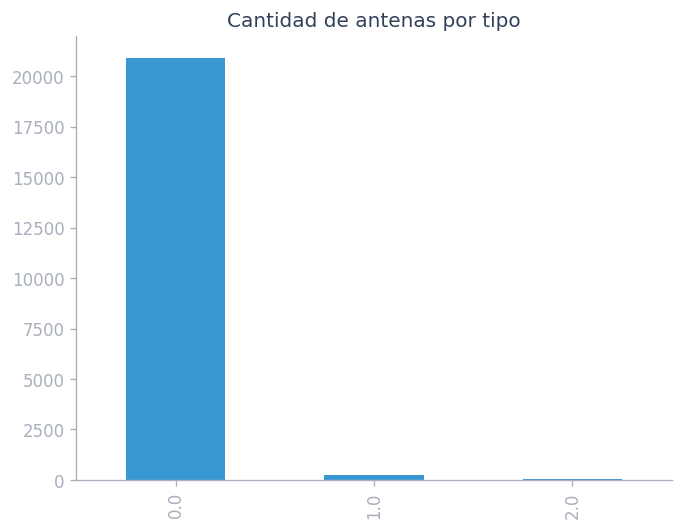

In [42]:
antenas = pd.read_parquet('../../Data/DataMart/Base/antenas.parquet')
antenas.drop_duplicates(subset=['serialNumber'],inplace=True, keep = 'last')
antenas['Antena'].value_counts().plot(kind='bar', color=mClr, title = 'Cantidad de antenas por tipo')

In [45]:
#Agregando antenas a equipos
print(f"Equipos shape: {equipos.shape}")
print("Columnas con vacíos en equipos: ", equipos.columns[equipos.isna().any()].tolist())
equipos_out = equipos.merge(antenas, on='serialNumber', how='left')
print(f"Equipos shape después de agregar antenas: {equipos_out.shape}")
print("Columnas con vacíos en equipos: ", equipos_out.columns[equipos_out.isna().any()].tolist())

Equipos shape: (769996, 106)
Columnas con vacíos en equipos:  ['latitude_gw', 'longitude_gw', 'cluster_gw', 'numberOfNeighbors_gw', 'h_gw', 'R_mean_gw', 'R_variance_gw', 'R_skewness_gw', 'G_mean_gw', 'G_variance_gw', 'G_skewness_gw', 'B_mean_gw', 'B_variance_gw', 'B_skewness_gw']
Equipos shape después de agregar antenas: (769996, 107)
Columnas con vacíos en equipos:  ['latitude_gw', 'longitude_gw', 'cluster_gw', 'numberOfNeighbors_gw', 'h_gw', 'R_mean_gw', 'R_variance_gw', 'R_skewness_gw', 'G_mean_gw', 'G_variance_gw', 'G_skewness_gw', 'B_mean_gw', 'B_variance_gw', 'B_skewness_gw', 'Antena']


In [ ]:
#Equipos sin información de gw
print("Columnas con vacíos en equipos: ", equipos_out.columns[equipos_out.isna().any()].tolist())
equipos_out = equipos_out[~equipos['latitude_gw'].isna()]
print("Columnas con vacíos en equipos: ", equipos_out.columns[equipos_out.isna().any()].tolist())
equipos_out.head()

In [ ]:
equipos_out.fillna(0, inplace=True)
equipos_out.head()

In [49]:
#Guardando equipos out
equipos_out.to_parquet('../../Data/DataMart/Views/DataViews/equipos_completo.parquet', index=False)